### Load packages and models

In [ ]:
!pip install jieba evaluate sacrebleu sacremoses datasets

In [1]:
# import pandas as pd
import numpy as np
import jieba
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
from datasets import Dataset
import pickle
# from easse.sari import sentence_sari
from evaluate import load
sari = load("sari")
with open("../data/Chinese/HSK_levels.pickle", 'rb') as handle:
    HSK_dict = pickle.load(handle)
# HSK_dict = HSK[HSK["level"]>3].to_dict()['level'] ### Only selecting HSK4 and above!

In [2]:
from transformers import BertTokenizer, BartForConditionalGeneration, Text2TextGenerationPipeline, AutoModelForSeq2SeqLM
tokenizer = BertTokenizer.from_pretrained("../data/models/batch_128_15625_500000", local_files_only=True)
model = BartForConditionalGeneration.from_pretrained("../data/models/batch_128_15625_500000", local_files_only=True)
# model = AutoModelForSeq2SeqLM.from_pretrained("fnlp/bart-base-chinese")

### Load data

In [3]:
# original mcts data
lines_orig = []
with open('../mcts-main/dataset/mcts.dev.orig', encoding="utf8") as f:
        lines_orig = f.read().splitlines()

lines_ref = []
with open('../mcts-main/dataset/mcts.dev.simp.0', encoding="utf8") as f:
        lines_ref = f.read().splitlines()

In [63]:
def tokenize_with_HSK(sentence, HSK_dict):
    split_sentence = jieba.lcut(sentence)
    HSK_sentence = ""
    for word in split_sentence:
        score = HSK_dict.get(word, 0)
        if score>0:
            HSK_sentence += f"{word}[{score}]"
        else:
            HSK_sentence += f"{word}"
    # HSK_sentence = "".join([f"{word}[{HSK_dict.get(word, 0)}]" for word in split_sentence])
    # HSK_sentence = f"[{score}]" + HSK_sentence
    return HSK_sentence

tokenizer.add_tokens(["[4]", "[5]", "[6]", "[7]"])
model.resize_token_embeddings(len(tokenizer))

def preprocess_data(filename: str, start: int, stop: int):
    lines = []
    lines_HSK = []
    with open(filename, encoding="utf8") as f:
        lines_orig = f.read().splitlines()
        for line in lines_orig[start:stop]:
            lines_HSK.append(tokenize_with_HSK(line, HSK_dict))
    return lines_HSK, lines_orig

In [64]:
start = 0
stop = 50
split = 20

lines_complex, lines_orig = preprocess_data('../mcts-main/pseudo_data/zh_selected.ori', start, stop)
lines_simple, lines_ref = preprocess_data('../mcts-main/pseudo_data/zh_selected.sim', start, stop)

data_dict = {'complex': lines_complex[start:split], 'simple': lines_simple[start:split]}
ds_train = Dataset.from_dict(data_dict)
data_dict = {'complex': lines_complex[split:stop], 'simple': lines_simple[split:stop]}
ds_eval = Dataset.from_dict(data_dict)

In [65]:
data_dict["complex"]

['丁玲亲属[6]及[7]全国百余名专家、学者[5]聚集[7]于[6]此[4]，深切[7]缅怀[7]这位杰出[6]的无产阶级革命[7]文艺[5]战士[4]、国内外享有盛誉的著名作家。',
 '“亚行”会议召开[4]的当天[6]上午，一些不明真相的群众[5]和学生先后[5]4次[4]冲击[6]人民大会堂。',
 '为了确保首都航空[4]、铁路、广播、电视通信枢纽[7]等重要目标的绝对安全，某团建立了以上百名党员干部为主体[5]的昼夜[7]巡逻队，对目标内外[6]进行细致[4]布防，有的党员连续几天几夜得不到休息，有的为救护战友[6]被暴徒打伤。',
 '由于共产党员的先锋[6]模范作用得到了较好[4]发挥[4]，这个部队[6]连续奋战60多个日夜[6]，没丢[5]一人一车、一枪一弹，所[6]警卫的一批重要目标安然无恙，因此受到上级[5]首长的赞扬[7]。',
 '其中大部分艺术片、纪录片[7]着重描写和反映[4]我中国人民解放军在党的领导下，紧密[4]地依靠[4]广大人民，在历年来的革命战争中所[6]进行的英勇斗争的故事。',
 '这支部队[6]虽然在抗击日本帝国主义[7]的战斗[4]中曾获得[4]一些微小的胜利，但由于没有巩固[6]的群众[5]基础，在与[6]装备[6]优良[4]，兵力强大的敌人[4]一次战斗[4]中，几乎[4]陷于击溃的危险境地[7]。',
 '这部影片是描写[4]我中国人民解放军第三野战军在1949年5月解放[5]上海的战役中进行了极为[7]复杂的艰苦[5]斗争[6]。',
 '搞不到名酒便[6]不结婚的青年人，险些让婚姻[7]变成酒的牺牲品，这种对待爱情和婚姻[7]的态度是不够严肃[5]的。',
 '国际考古捷发现近四千年前墓葬群据[6]报道，捷克斯洛伐克考古学家不久前在北捷克州霍穆托夫市附近[4]发现纪元前两千年至[5]一千八百年期间[4]的古墓葬群，共有六十座古墓。',
 '要[4]坚持法治引领[7]，严格[4]司法程序，正确处理打击犯罪与[6]保障人权、实体[7]公正[5]与[6]程序[4]公正[5]、严格执法与[6]文明执法的关系，实现维护[4]人民权益[7]与[6]维护[4]社会秩序相统一[4]。',
 '此外[4]，希望人民日报能报道些[4]高等学校中培养[4]工农干部[7]的好[4]经验。',
 '我与[6]全体高棉人民一道[6]

In [66]:
# tokenize data
max_length = 128
def batch_tokenize_data(data):
    inputs = [example for example in data["complex"]]
    targets = [example for example in data["simple"]]

    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True)
    labels = tokenizer(targets, max_length=max_length, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data_train = ds_train.map(batch_tokenize_data, batched=True)
tokenized_data_eval = ds_eval.map(batch_tokenize_data, batched=True)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

### Set up trainer

In [70]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # Decode the predicted tokens and labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Post-process to clean up text
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # compute SARI score
    sari_score = sari.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels],
        sources=decoded_preds
    )

    return {"sari": sari_score["sari"]}

training_args = TrainingArguments(
    output_dir="./bart_simplification",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_data_train,
    eval_dataset = tokenized_data_eval,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'predict_with_generate'

### Train

In [ ]:
trainer.train()

### Evaluate

In [8]:
idx = 100
sentence = lines_orig[idx]
text2text_generator = Text2TextGenerationPipeline(model, tokenizer)
output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
print(sentence)
print(output)
print(lines_ref[idx])

Device set to use cpu


英国航空公司有关人士说，目前采用条形码方法对托运行李进行管理，但有时会出现因条形码丢失或损坏的情况而导致信息无法读出。
英国航空公司相关人士表示，目前采用条形码方法管理托运行李，但有时会因条码丢失或损坏而[4]无法[4]读出信息。
英国航空公司有关人士说，目前采用条形码方法对托运行李进行管理，但有时会因条形码丢失或损坏的情况而出现信息没有办法读出的情况。


In [67]:
# Another way to do the same thing:
input_ids = tokenizer(sentence, return_tensors='pt', max_length=256, padding="max_length", truncation=True)
outputs = model.generate(input_ids=input_ids["input_ids"], max_length=256, num_beams=4, penalty_alpha=0.6, top_k=4)
print(str(tokenizer.batch_decode(outputs, skip_special_tokens=True)).replace(" ",""))

['最近几天，，在一些交通要道的交叉口，发生爆炸事件[[]']


In [71]:
sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[idx]]])

{'sari': 66.66666666666666}

In [10]:
### Evaluate sari distribution
text2text_generator = Text2TextGenerationPipeline(model, tokenizer)
sari_pseudo = [] # for pseudo cross-lingual data
sari_mcts = [] # for curated mcts data
# for idx in range(1000):
#     sentence = lines_orig[idx]
#     output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
#     sari_pseudo.append(sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[idx]]])['sari'])

for idx in range(len(lines_orig)):
    sentence = lines_orig[idx]
    output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
    sari_mcts.append(sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[idx]]]))

Device set to use cpu


In [81]:
print(sari_score)

[83.33333333333334, 91.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 66.66666666666666, 83.33333333333334, 91.66666666666666, 91.66666666666666, 91.66666666666666, 66.66666666666666, 66.66666666666666, 91.66666666666666, 91.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 91.66666666666666, 83.33333333333334, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 83.33333333333334, 66.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 75.0, 91.66666666666666, 66.66666666666666, 91.66666666666666, 91.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 68.75, 66.66666666666666, 83.33333333333334, 77.77777777777779, 91.66666666666666

In [123]:
import pickle
with open('sari_scores_mcts.pkl', 'wb') as f:
    pickle.dump(sari_score, f)
    with open('sari_scores_mcts.pkl', 'wb') as f:
    pickle.dump(sari_score, f)

In [14]:
sari_score = []
for item in sari_mcts:
    sari_score.append(item['sari'])

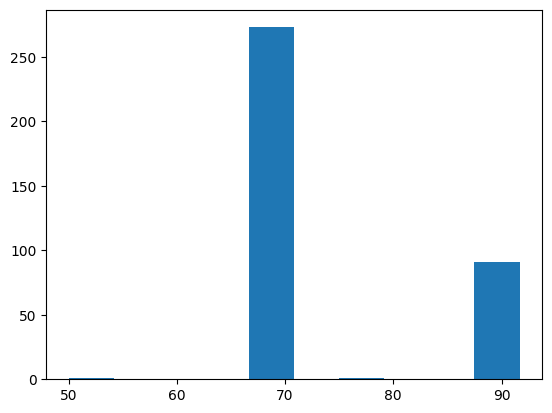

In [15]:
import matplotlib.pyplot as plt
plt.hist(sari_score, bins=10);

In [ ]:
text2text_generator = Text2TextGenerationPipeline(model, tokenizer)
sari_score = []
for idx in range(len(lines_orig)):
    sentence = lines_orig[idx]
    output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
    sari_score.append(sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[0][idx]]]))

In [122]:
idx = 10
sentence = lines_orig[idx]
output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
print(sentence)
print(output)
print(lines_ref[0][idx])
print(sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[0][idx]]]))

这位官员说，煤层气是具有很大开发潜力的“绿色能源”，已被列为中国新能源发展战略的重点之一。
煤层气是具有很大开发潜力的“绿色能源”。
这位官员说，煤层气是可以开发的“绿色能源”，是中国重点发展的新能源。
{'sari': 91.66666666666666}
